For MCV2, we try to minimize the difference between the cell-cell distance vectors for the denoised and ground-truth data.

If $x$ and $y$ are such points (ground truth), with independent samples $x_1, x_2, y_1, y_2$, then we have

$\vert (f(x_1) - f(y_1)) - (x_2 - y_2) \vert^2 \approx \vert (f(x_1) - f(y_1)) - (x - y) \vert^2$.

We may rearrange the LHS to

$\vert (f(x_1) - x_2) - (f(y_1) - y_2) \vert^2,$

which are simply the differences between the residuals $f(x_1) - x_2$.

In [1]:
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error
from scipy.sparse import issparse
from matplotlib import pyplot as plt

%matplotlib inline

import numpy as np
from tqdm import tqdm

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from downstream import *
from sweep import *
from data import *

In [25]:
symsim = load_symsim(suffix = '2k')
blood = load_blood()
sc.pp.subsample(blood, fraction=0.1)

# SymSim

In [26]:
adata = symsim

In [27]:
denoised_symsim = sweep_pca_mcv2(adata, n_neighbors=70)

100%|██████████| 18/18 [00:32<00:00,  1.82s/it]


In [28]:
def get_scalar(denoised, key):
    """Plot a scalar against the parameters used to sweep."""
    return np.array([adata.uns[key] for adata in denoised])

Note that MCV2 will be equal to $2*n_{genes}*MCV$ if the residuals are (close to) mutually orthogonal. If they have bias, then MCV2 will be lower.

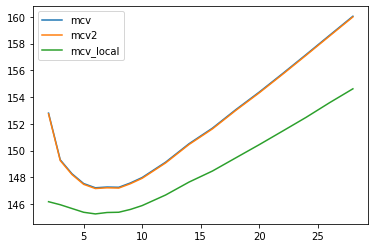

In [32]:
plt.plot(get_scalar(denoised_symsim, 'denoiser_param'),
         2*denoised_symsim[0].X.shape[1]*get_scalar(denoised_symsim, 'mcv'), label='mcv')

plt.plot(get_scalar(denoised_symsim, 'denoiser_param'),
         get_scalar(denoised_symsim, 'mcv2'), label='mcv2')

plt.plot(get_scalar(denoised_symsim, 'denoiser_param'),
         get_scalar(denoised_symsim, 'mcv2_local'), label='mcv_local')

plt.legend()

In [35]:
from molecular_cross_validation.util import expected_sqrt

In [36]:
true_means = symsim.obsm['X_true'] * (symsim.X.sum(1, keepdims=True)/2) / (symsim.obsm['X_true'].sum(1, keepdims=True))

In [37]:
expected_gt = expected_sqrt(true_means)

In [38]:
for adata in denoised_symsim:
    gt = mean_squared_error(adata.X, expected_gt)
    gt2 = (pdist(adata.X - expected_gt, metric='euclidean')**2).mean()
    adata.uns['gt'] = gt
    adata.uns['gt2'] = gt2

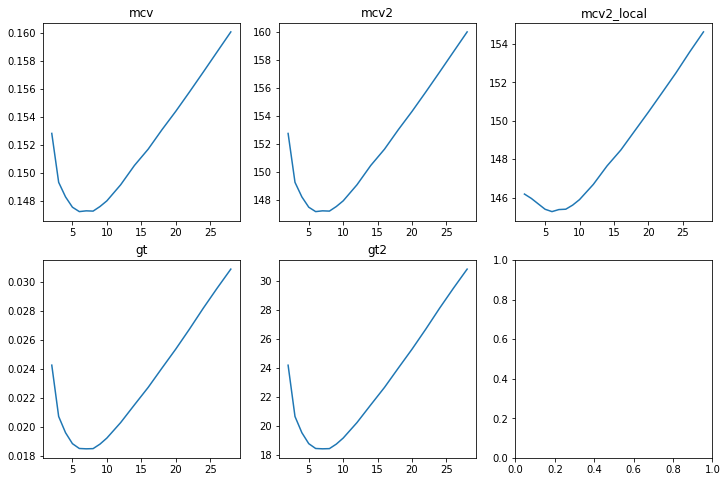

In [39]:
plot_scalars(denoised_symsim, ['mcv', 'mcv2', 'mcv2_local', 'gt', 'gt2'])

In [41]:
cluster_denoised(denoised_symsim, 'pop', sqrt=False, adaptive=True, kmeans=True)

  0%|          | 0/18 [00:00<?, ?it/s]

There are 5 true clusters.


100%|██████████| 18/18 [01:45<00:00,  5.84s/it]


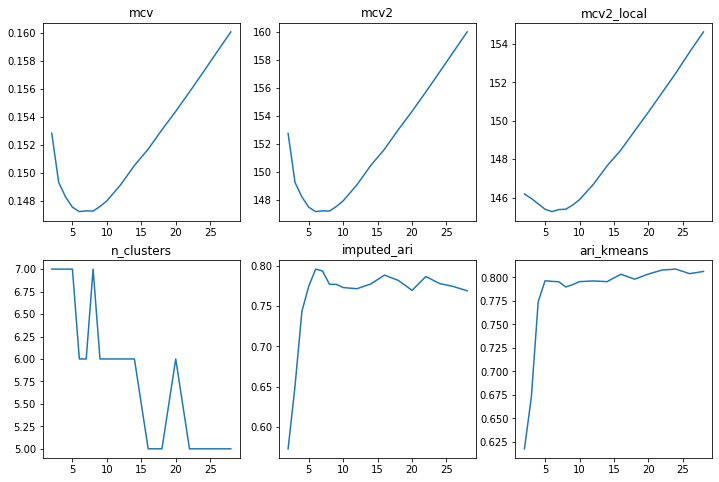

In [42]:
plot_scalars(denoised_symsim, ['mcv', 'mcv2', 'mcv2_local',
                               'n_clusters', 'imputed_ari', 'ari_kmeans'])

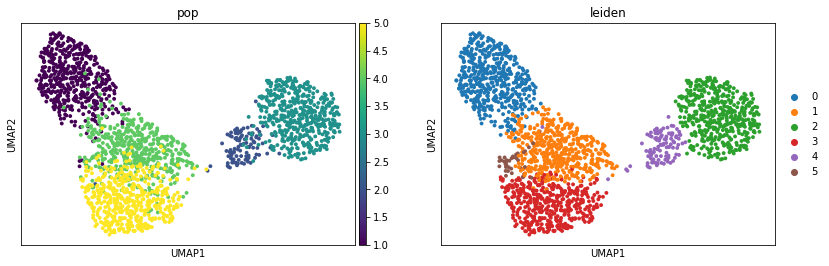

In [45]:
sc.pl.umap(extract_best(denoised_symsim), color=['pop', 'leiden'])

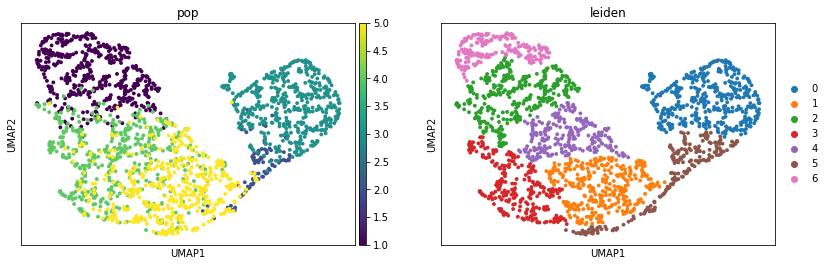

In [48]:
sc.pl.umap(denoised_symsim[0], color=['pop', 'leiden'])